### Transfer Learning

Autoren: Hannes Bornemann, Michelle Winkle

In diesem Notebook wird gezeigt, wie Transfer Learning genutzt werden kann um Gemüse zu klassifizieren.


In [1]:
import os 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pandas as pd 

# setzen der Bildgröße für InceptionV3
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_CHANNELS=3

# setzen der Bildanzahl, nach der das Modell die Gewichte anpasst
batch_size = 20

In [18]:
# Pfade zu den Ordnern
folder_potato = 'photos_reduced/Kartoffel_reduced'
folder_onion = 'photos_reduced/Zwiebel_reduced'
folder_carrot = 'photos_reduced/Karotte_reduced'

# Initialisierung der Listen
categories = []
filenames = []

# Durchlaufen des Kartoffel-Ordners
for filename in os.listdir(folder_potato):
    categories.append(0)  # Kartoffel-Kategorie
    filenames.append(os.path.join(folder_potato, filename))

# Durchlaufen des Zwiebel-Ordners
for filename in os.listdir(folder_onion):
    categories.append(1)  # Zwiebel-Kategorie
    filenames.append(os.path.join(folder_onion, filename))

# Durchlaufen des Karotte-Ordners
for filename in os.listdir(folder_carrot):
    categories.append(2)  # Karotte-Kategorie
    filenames.append(os.path.join(folder_carrot, filename))

# Erstellung des DataFrames
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Ersetzen der Integer Werte für die Klasse durch strings 
df["category"] = df["category"].replace({0: 'potato', 1: 'onion', 2: 'carrot'}) 

# Teilen der Daten in Traingsdaten und Validierungsdaten
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

###-----------------------------------------------------------------------------------------
# Pfade zu zusätzlichen Testdaten
folder_potato_burghart = 'photos_reduced_burghart/Kartoffel_reduced'
folder_onion_burghart = 'photos_reduced_burghart/Zwiebel_reduced'
folder_carrot_burghart = 'photos_reduced_burghart/Karotte_reduced'

categories_burghart = []
filenames_burghart = []

for filename in os.listdir(folder_potato_burghart):
    categories_burghart.append(0)  # Kartoffel-Kategorie
    filenames_burghart.append(os.path.join(folder_potato_burghart, filename))

for filename in os.listdir(folder_onion_burghart):
    categories_burghart.append(1)  # Zwiebel-Kategorie
    filenames_burghart.append(os.path.join(folder_onion_burghart, filename))

for filename in os.listdir(folder_carrot_burghart):
    categories_burghart.append(2)  # Karotte-Kategorie
    filenames_burghart.append(os.path.join(folder_carrot_burghart, filename))

validate_df_burghart = pd.DataFrame({
    'filename': filenames_burghart,
    'category': categories_burghart
})

# Ersetzen der Integer Werte für die Klasse durch strings 
validate_df_burghart["category"] = validate_df_burghart["category"].replace({0: 'potato', 1: 'onion', 2: 'carrot'}) 

validate_df_burghart = validate_df_burghart.reset_index(drop=True)
###-----------------------------------------------------------------------------------------

train_number = len(train_df)
validate_number = len(validate_df)
validate_number_burghart = len(validate_df_burghart)
print ('Anzahl der Bilder (Train):',train_number)
print ('Anzahl der Bilder (Validate):',validate_number)
print ('Anzahl der Bilder (Validate Burghart):',validate_number_burghart)

Anzahl der Bilder (Train): 2646
Anzahl der Bilder (Validate): 662
Anzahl der Bilder (Validate Burghart): 21


Im Folgenden wird das Modell erstellt, wobei das Netz zur Feature Extraction (Kodierungsblock) vom Inception_V3 Modell übernommen wird. Dieser muss nicht trainiert werden, was enormen Rechenaufwand spart. Der nachgelagerte Prädikationsblock nutzt die Merkmale für die Vorhersage der Klasse. Dieser muss trainiert werden und enthält eine an die spezifische Aufgabe angepasste Ausgabeschicht mit 3 Neuronen für die 3 möglichen Klassen und der softmax-Aktivierungsfunktion (da zb. mehr Klassen als 2 zu unterscheiden gibt, dazu könnte "binary" genutzt werden)


In [19]:
from tensorflow.keras import layers
from tensorflow.keras import models 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers

# Erstellung eines leeren sequentielles Modells
model = models.Sequential()
# Kodierungsblock (Featature Extractor) von InceptionV3 übernehmen (Prädikationsblock auslassen mit include_top=False)
# Input Shape benötigt Größe 224x224x3, Testdaten werden später dirch den ImageDataGenerator darauf angepasst
base_model = InceptionV3(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
# Hinzufügen des InceptionV3 Netzes zum Modell 
model.add(base_model)

### definieren des Prädikationsblocks ####
# Flatten Layer um die 3D Ausgabe in 1D umzuwandeln
model.add(layers.Flatten())
# voll verknüpfte Schichten mit 256 bzw. 512 Neuronen und ReLU Aktivierungsfunktion
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
# letzte Schicht mit 3 Neuronen und Aktivierungsfunktion für Multiklassen Klassifikation (Softmax) 
model.add(layers.Dense(3, activation='softmax')) # 3 Klassen: Zwiebel, Karotte, Kartoffel
# deaktivieren des Training des Basis Modells 
base_model.trainable = False 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               13107456  
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 35043363 (133.68 MB)
Trainable params: 13240579 (50.51 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [4]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(1e-4),metrics=['acc'])

### Vorbereiten der Daten


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescalen der Trainingsdaten von 255 auf 1 und Data Augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
    )

# rescalen der Testdaten von 255 auf 1
test_datagen = ImageDataGenerator(
    rescale = 1./255
    )

# laden der Bilder über den ImageDataGenerator, dabei Anpassung der Bildgröße auf 224x224
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size  = batch_size,
    class_mode = 'categorical' 
)

test_generator = test_datagen.flow_from_dataframe(
    validate_df,
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size  = batch_size,
    class_mode = 'categorical' 
)
###-----------------------------------------------------------------------------------------
test_generator = test_datagen.flow_from_dataframe(
    validate_df_burghart,
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size  = batch_size,
    class_mode = 'categorical' 
)
###-----------------------------------------------------------------------------------------

Found 2646 validated image filenames belonging to 3 classes.
Found 662 validated image filenames belonging to 3 classes.
Found 21 validated image filenames belonging to 3 classes.


### Trainieren des Netzes


In [6]:
history = model.fit(train_generator,
steps_per_epoch=100,
epochs = 10,
validation_data = test_generator,
validation_steps=validate_number//batch_size)
# validate_number = Gesamtanzahl der für Validierung genutzten Bilder
# batch_size = Anzahl der Bilder, die pro "step" durch das Modell laufen
# epochs =  hier werden mehrere "steps" durchlaufen
#           bilder pro epoche = batch_size * steps_per_epoch
# validation_steps = Anzahl der Schritte bis Gewichte angepasst werden

Epoch 1/10


100/100 [==============================] - 103s 976ms/step - loss: 0.2104 - acc: 0.9043 - val_loss: 0.0297 - val_acc: 0.9848
Epoch 2/10
100/100 [==============================] - 99s 988ms/step - loss: 0.0703 - acc: 0.9642 - val_loss: 0.0266 - val_acc: 0.9894
Epoch 3/10
100/100 [==============================] - 96s 956ms/step - loss: 0.0458 - acc: 0.9738 - val_loss: 0.0193 - val_acc: 0.9909
Epoch 4/10
100/100 [==============================] - 91s 909ms/step - loss: 0.0319 - acc: 0.9844 - val_loss: 0.0165 - val_acc: 0.9894
Epoch 5/10
100/100 [==============================] - 87s 870ms/step - loss: 0.0405 - acc: 0.9824 - val_loss: 0.0255 - val_acc: 0.9833
Epoch 6/10
100/100 [==============================] - 87s 877ms/step - loss: 0.0346 - acc: 0.9794 - val_loss: 0.0405 - val_acc: 0.9758
Epoch 7/10
100/100 [==============================] - 86s 864ms/step - loss: 0.0339 - acc: 0.9829 - val_loss: 0.0370 - val_acc: 0.9803
Epoch 8/10
100/100 [==============================] 

In [7]:
# Das Modell kann zum Vergleichen von unterschiedlichen Parametern des Prädikationsblocks abgespeichert werden
# model.save('cats_dogs_1.h5')

### Auswerten des Netzes


In [8]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 640x480 with 0 Axes>

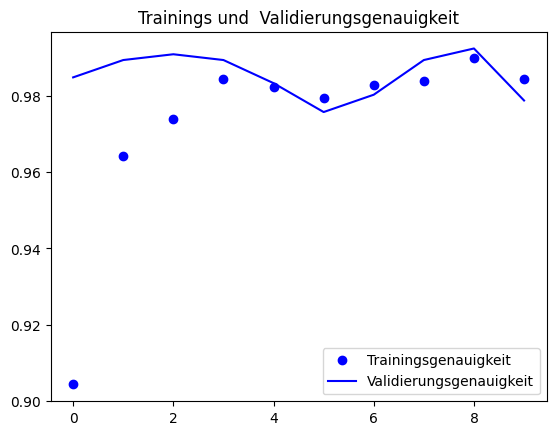

<Figure size 640x480 with 0 Axes>

In [9]:
plt.plot(epochs,acc,'bo',label='Trainingsgenauigkeit')
plt.plot(epochs,val_acc,'b',label='Validierungsgenauigkeit')
plt.title('Trainings und  Validierungsgenauigkeit')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

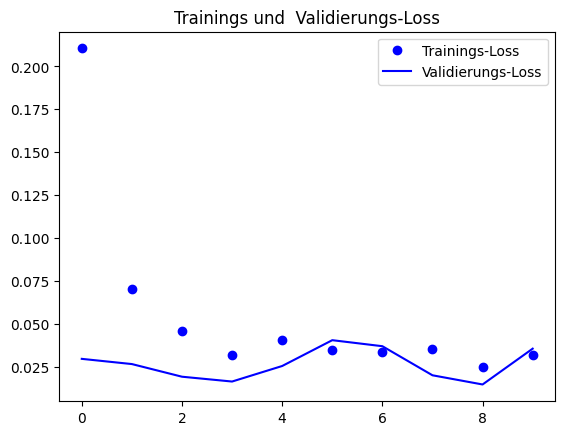

<Figure size 640x480 with 0 Axes>

In [10]:
plt.plot(epochs,loss,'bo',label='Trainings-Loss')
plt.plot(epochs,val_loss,'b',label='Validierungs-Loss')
plt.title('Trainings und  Validierungs-Loss')
plt.legend()
plt.figure()